In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [25]:
# Load all the data/images into tensorflow
"""
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs
)
"""
IMAGE_SIZE = 256
BATCH_SIZE = 32 # Usually it's a standard, so 32
CHANNELS = 3 # 3 RGB Channels
EPOCHS = 5 # It can be any value, but 50 is appropriate
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "TomatoVillage",
    shuffle=True,
    # All images are 256x256 pixels
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 16011 files belonging to 10 classes.


In [26]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [27]:
len(dataset) # 501 as we have total 501 batches with each batch of 32 images

501

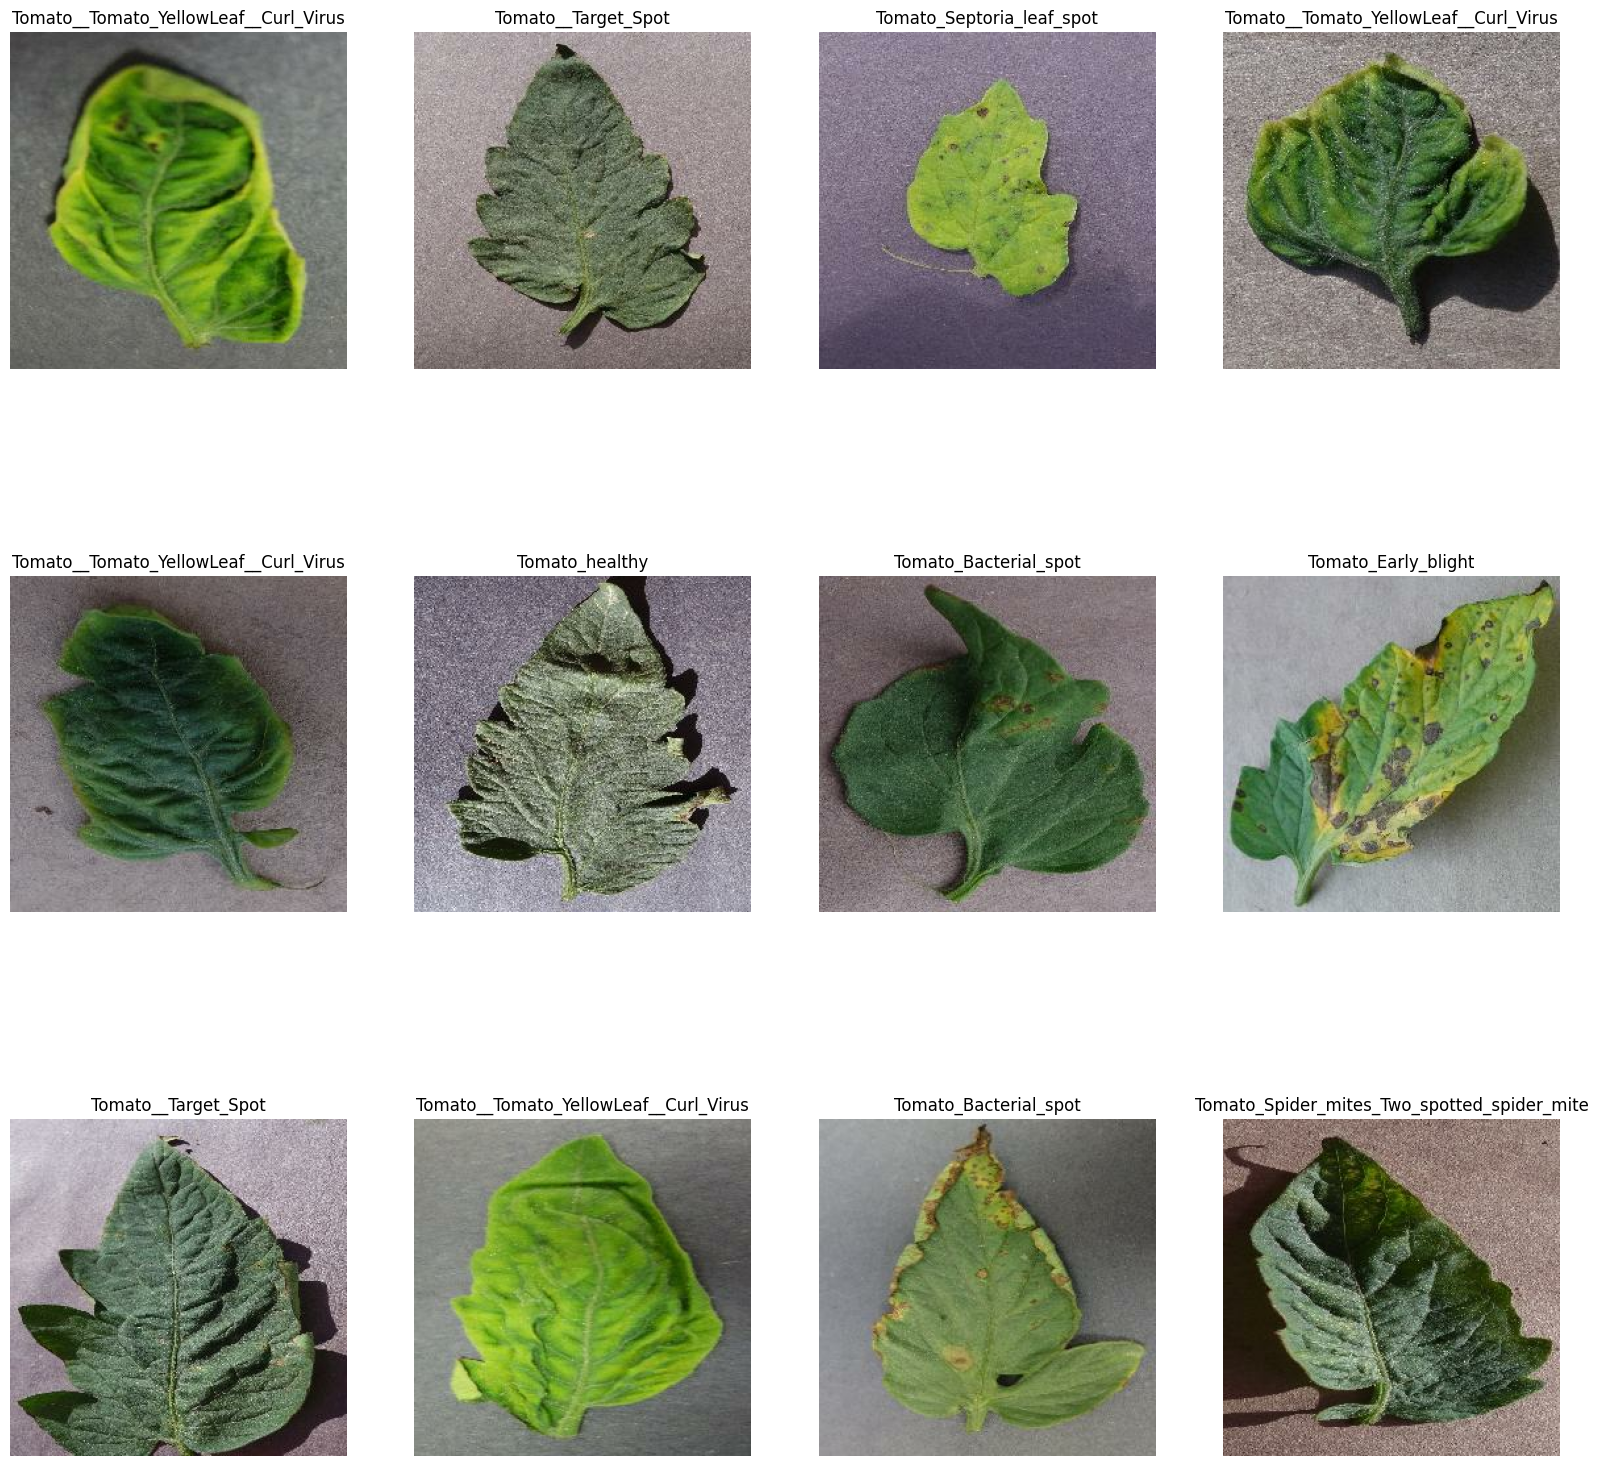

In [28]:
# Increase area for each image being printed to 10x10
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    # Display first 12 images of the first batch of 32 images
    for i in range(12):
        # Make a subplot, like a matrix of images
        ax = plt.subplot(3,4,i+1)
        
        # Everytime we see different image as shuffle=True, so 1st image keeps getting changed
        plt.imshow(image_batch[i].numpy().astype("uint8")) # It is float, so convert to int
    
        # label_batch[0] returns index 0, 1 or 2
        # so we do, class_names[label_batch[0]]
        # class_names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
        plt.title(class_names[label_batch[i]]) # Which type of image is this, is it early blight, late blight or healthy
    
        # Remove the axis
        plt.axis("off") 


    
    """
    print(image_batch[0].numpy()) # Convert Tensor to numpy array, it gives a 3d array of the first image at 0th position where each value is between 0 to 255
    print(image_batch[0].shape) # (256, 256, 3)
    
    print(image_batch.shape) # (32, 256, 256, 3) : 32 images, each image is 256,256, 3 is RGB channels
    print(label_batch.numpy()) # Convert tensor to numpy array:
    # [1 1 2 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1] : 3 classes so, 0 for early blight, 1 for late blight, 2 for healthy
    """

In [29]:
"""
Spliting DataSet

80% ==> training
20% ==> 10% validation, 10% testing
We run 50 EPOCHS
1 epoch means: train the model on the 80% data and then at the end of 1 epoch, validate it using 10% validation data
and do this 50 times
once this cycle is completed
test the model using the 10% testing data
"""

'\nSpliting DataSet\n\n80% ==> training\n20% ==> 10% validation, 10% testing\nWe run 50 EPOCHS\n1 epoch means: train the model on the 80% data and then at the end of 1 epoch, validate it using 10% validation data\nand do this 50 times\nonce this cycle is completed\ntest the model using the 10% testing data\n'

In [30]:
# Function to do all the  data splitting calculations automatically
# Parameters:
"""
ds: dataset
train_split: ratio of training data
val_split: ratio of validation data
test_split: ration of testing data
"""
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    # Size of dataset
    ds_size = len(ds)

    # If shuffle is True then shuffle the dataset
    if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12) # seed is for predictiblity, so if you have same seed everytime, it give you same result everytime, it can be any number (5, 7, ect...)

    # Training Data Size
    # 80% of dataset(ds) and convert to int, so that we don't get float values
    train_size = int(train_split * ds_size)

    # Validation Data Size
    val_size = int(val_split * ds_size)

    # Training Data Set
    # Take the first (train_size) batches out of all the batches of data, where each batch has 32 images
    train_ds = ds.take(train_size)

    # From the remaining 20% of data, take first 10% or (val_size) of data as validation data
    val_ds = ds.skip(train_size).take(val_size)

    # From the reamining 20% data, skip the first 10% or (val_size) of data and use the remaining data as testing data
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [31]:
# Calling function on the dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [32]:
# Caching of the training data set
# train_ds.cache(): It will read the image from the memory in the 1st iteration, and when you need the same image, it will keep that image in the memory, so that in every EPOCh we do not need to keep loading it again and again, which improves the performance of the pipeline
# shuffle: will shuffle the images
# prefetch: If we are using GPU and CPU then, if GPU is busy training the data then prefetch will load the next set of batch from the disk and that improves the performance.

# Explaination for : train_ds.cache().shuffle(1000).prefetch()
"""
 (Why use prefectch?)
 Refer Image: CPU_GPU_1
 When loading images, say 32 images at a time and say we have a GPU (eg, Titan RTX)
 When it(GPU) is training, we are not using CPU when GPU is training because CPU is sitting idle
 then when GPU is done, CPU again reads the batch and then GPU is added, so for example in image it takes total 12 seconds

 But when using prefetch and caching : Refer CPU_GPU_2
 While GPU is training batch 1, CPU will be loading next batch(batch 2), that's what prefetch does basically

 (Why use cache?)
 cache on the other hand, refer CACHING_1 image
 In that, in the first row the blue part represents the images being read
 So in the first EPOCH we read images, now again in the 2nd EPOCH same images are being read (Which can be seen in the 2nd blue part)

 But if we use cache(), refere CACHING_2 image
 In this image, we don't see the blue block again, we see it only once
 So by doing that we save time reading those images.
"""
# prefetch(buffer_size=tf.data.AUTOTUNE) : Let tensorflow determine how many batches to load while GPU is training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Similarly for validation and testing data set
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# So far datasets are optimized for training performance, so training will run fast.

In [33]:
# Creating a layer to supply to the final model
resize_and_rescale = tf.keras.Sequential([ # Layers for pre-processing
    # Re-size every image to 256 x 256
    #Question: Images are already 256 x 256, why re-size it ?
    #Ans: This resize_and_rescale layer will eventiually go to the final model that we are creating and when we
    #     have a trained model and when it starts predicting, during prediction if any image that is being supplied to model,
    #     which is not 256 x 256, it will automatically re-size it.
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    
    # It will scale the image to 255
    tf.keras.layers.Rescaling(1.0/255),
])

In [34]:
# Data Augmentation to make the model robust
"""
# Let's say a model is trained based on certain set of images, now when we upload a new image for which we want the prediction
if that image is rotated or is different in contrast then other images in the dataset on which the model is trained
then the model will not perform good.
for that we need data augentation concept.

# What do we do in data augmentation?
# Refer DATA_AUGMENTATION image

Let' says we have an original image in the training data set, using this same image we create 4 new TRAINING samples by applying different transformations to the original image
like horizontal flip, contrast, rotating the image or zooming
Now we will use all these 5 images (1 original + 4 new images) for training the model, which makes the model completely robust

so now, if this model is used in real world, where a rotated image is being supplied to the model, model knows how to predict that.
"""
# Applying random flip and rotation
data_augmentation = tf.keras.Sequential([ # Layers for pre-processing
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# These layers will be used in the actual model.

In [35]:
# Input Shape
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS) # This is the format of the input
# Number of classes
n_classes = len(class_names)

# Building the Convolutional Neural Network (CNN) or Building the model
model = models.Sequential([
    
    # Layer 1: When feed an image, first resize and rescale it
    resize_and_rescale,
    
    # Layer 2: Do the flips and random rotations to generate new samples
    data_augmentation, 
    
    # Layer 3: Convolutional Layer
    # kernel_size is the size of the filters: Refer image FILTER (In image green box is 3x3 filter), so kernel_size is 3x3
    # What's the filter: REFER FILTER_2 image
    # In image we have example of Kola's image detection
    # 1 filter is to detect eye, another to detect nose, and another to detect ears
    # if you have eye, nose, ears of Koala, we can say the image has Koalas head too
    # similarly 1 filter to detect hands and legs, we can conclude that image has Koalas body too
    # if it has both Koals head and body, means it can be a koalas image, so flattern that and kinda figure that out
    # In example, we have 5 layers (eye, nose, ears, hands, legs)

    # For this model, we use 32 layers
    # Why 32 ?
    # Trail and Error, we need a lot of layers where we can detect edges, small features
    # Filter_Size: (3,3)
    # activation = 'relu' as it is fast to compute
    # input_shape: input_shape = (IMAGE_SIZE, IMAGE_SIZE)
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape), 

    # layer 4: Pooling Layer(Like max pooling etc ...): Refer POOLING image
    # Benifit: Preserving the features while reducing the size of the image, which is very helpful computation vise.
    layers.MaxPooling2D((2,2)), 

    # Few extra Convolutional and Pooling layers: (After some trail and error I figured I need to stack a few conv and pooling layers)
    # 32 and 64 are also figured by trial and error method.
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    # Next refer FILTER_2 image, now we need to flatten it, so it's an array of neurons, so we have a hidden dense layer and then a final output classification layer
    layers.Flatten(),

    # Adding a dense layer of 64 neurons
    layers.Dense(64, activation='relu'),

    # Last layer will have 3 neurons with softmax activation function
    # softmax function normalizes the probablity of the classes
    layers.Dense(n_classes, activation='softmax')
])

# Build the model
model.build(input_shape = input_shape)

# For Layer 3
"""
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
"""

"\ntf.keras.layers.Conv2D(\n    filters,\n    kernel_size,\n    strides=(1, 1),\n    padding='valid',\n    data_format=None,\n    dilation_rate=(1, 1),\n    groups=1,\n    activation=None,\n    use_bias=True,\n    kernel_initializer='glorot_uniform',\n    bias_initializer='zeros',\n    kernel_regularizer=None,\n    bias_regularizer=None,\n    activity_regularizer=None,\n    kernel_constraint=None,\n    bias_constraint=None,\n    **kwargs\n)\n"

In [36]:
# Model Architecture is ready, still training is not done yet

# Model Summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [37]:
# Total params: 183,747 : These are the weights that need to be trained (no.of weights)

# So 1st define the neural network architecture, then compile using optimizers like (adam: it is a famous optimizer), then define loss function, metrics
# Like in each EPOCH, what kind of metric will you use to track the gradient descent
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train the network
# We will record the history of every EPOCH in history parameter to make some plots
history = model.fit(
    train_ds, 
    epochs=EPOCHS, # 50 EPOCHS
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds # During each EPOCH this validation data helps to track the accuracy
)

Epoch 1/5


